In [ ]:
import numpy as np
from PIL import Image
from glob import glob
import cv2
import matplotlib.pyplot as plt


In [ ]:
mask_list=glob('../../data/segmentationDDH/predict/DeepLabV3Plus/GT/**/')
pred_DeepLabV3Plus_list=glob('../../data/segmentationDDH/predict/DeepLabV3Plus/pred/**/')
pred_NestedUNet_list=glob('../../data/segmentationDDH/predict/NestedUNet/pred/**/')
pred_PAN_list=glob('../../data/segmentationDDH/predict/PAN/pred/**/')
pred_UNet_list=glob('../../data/segmentationDDH/predict/UNet/pred/**/')

In [ ]:
#2D mask image pca algorithm function
def pca(img):
    img = img.astype(np.float32)
    img = img - np.mean(img)
    h, w = img.shape
    if h > w:
        img = img.T
        h, w = img.shape
    img_cov = np.dot(img, img.T) / (h * w - 1)
    eig_val, eig_vec = np.linalg.eig(img_cov)
    sort_idx = np.argsort(eig_val)[::-1]
    eig_val = eig_val[sort_idx]
    eig_vec = eig_vec[:, sort_idx]
    return eig_val, eig_vec
image=Image.open(mask_list[0]+'2.png')
# pca value image overlay plot

pca(np.array(image))[1]

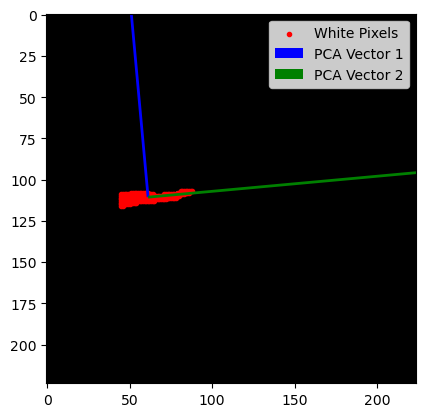

In [52]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color

# Load the binary image (replace 'your_binary_image.png' with your actual image file)
image_path = mask_list[2]+'2.png'
binary_image = io.imread(image_path, as_gray=True)

# Extract the coordinates of the white pixels
white_pixel_coords = np.argwhere(binary_image == 255)

# Create a PCA object
pca = PCA(n_components=2)

# Fit the PCA model to the white pixel coordinates
pca.fit(white_pixel_coords)

# Transform the white pixel coordinates using PCA
pca_vector = pca.transform(white_pixel_coords)

# Plot the binary image
plt.imshow(binary_image, cmap='gray')

# Plot the PCA vector on the binary image
plt.scatter(white_pixel_coords[:, 1], white_pixel_coords[:, 0], c='red', marker='.', label='White Pixels')
plt.quiver(pca.mean_[1], pca.mean_[0], pca.components_[0, 0], pca.components_[0, 1], scale=0.1, color='blue', label='PCA Vector 1')
plt.quiver(pca.mean_[1], pca.mean_[0], pca.components_[1, 0], pca.components_[1, 1], scale=0.1, color='green', label='PCA Vector 2')


plt.legend()
plt.show()


In [50]:
pca.components_

array([[-0.09104745,  0.99584656],
       [ 0.99584656,  0.09104745]])